## Install and import libraries

In [ ]:
!pip3 install scanpy anndata leidenalg louvain igraph

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
def evaluate_model(model, X_test, y_test, labels, sample_weights=None):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, sample_weight=sample_weights, target_names=labels))
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted', sample_weight=sample_weights)
    print(f"Weighted AUROC: {auc:.4f}")

## Load preprocessed datasets

In [ ]:
train_path = '/content/drive/MyDrive/Colab_Notebooks/CS7641_ML/data/training_dataset.csv'
test_path = '/content/drive/MyDrive/Colab_Notebooks/CS7641_ML/data/test_dataset.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df['pam50_+_claudin-low_subtype'].value_counts()

,count
pam50_+_claudin-low_subtype,
LumA,552
LumB,369
Her2,169
Basal,162
claudin-low,160
Normal,109
NC,2


In [ ]:
train_df = train_df[train_df['pam50_+_claudin-low_subtype'] != 'NC']
test_df = test_df[test_df['pam50_+_claudin-low_subtype'] != 'NC']

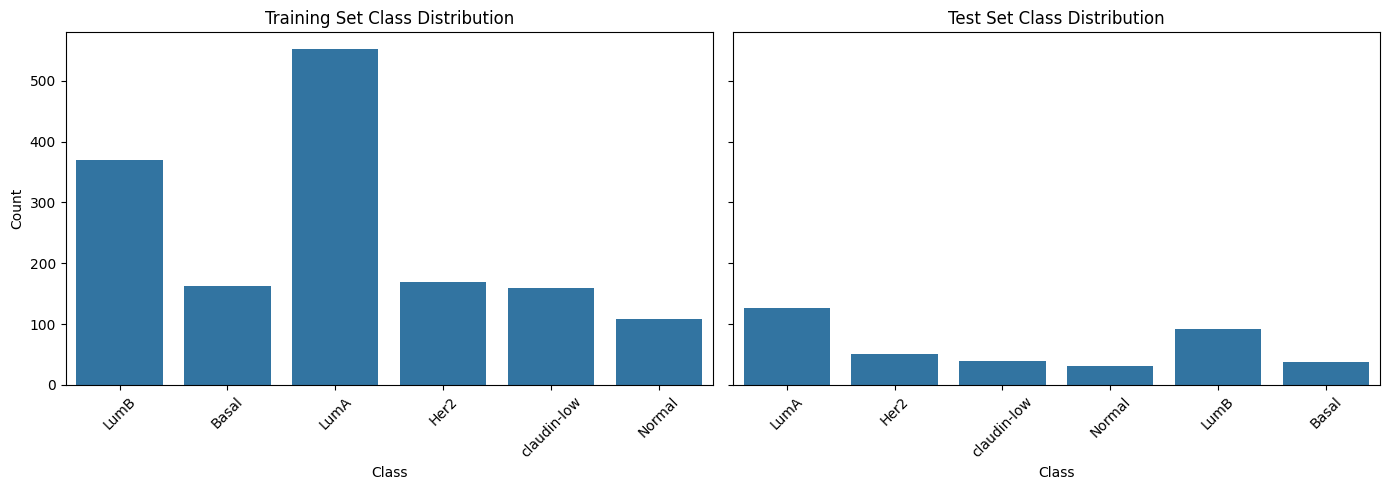

In [ ]:
# Plot side-by-side class distributions
target_col = 'pam50_+_claudin-low_subtype'
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.countplot(x=train_df[target_col], ax=axes[0])
axes[0].set_title("Training Set Class Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(x=test_df[target_col], ax=axes[1])
axes[1].set_title("Test Set Class Distribution")
axes[1].set_xlabel("Class")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Separate features and target

In [ ]:
X_train = train_df.drop(columns=['pam50_+_claudin-low_subtype'])
y_train = train_df['pam50_+_claudin-low_subtype']

X_test = test_df.drop(columns=['pam50_+_claudin-low_subtype'])
y_test = test_df['pam50_+_claudin-low_subtype']

In [ ]:
# Compute balanced sample weights
sample_weights_train = compute_sample_weight(class_weight='balanced', y=y_train)
sample_weights_test = compute_sample_weight(class_weight='balanced', y=y_test)

## Encode target labels

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

## Define parameters

In [ ]:
# Hyperparameter space
param_grid_l2 = {
    'C': np.logspace(-4, 2, 10), # increase it when...
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg', 'sag'],
    'max_iter': [1000]
}

param_grid_saga = {
    'C': np.logspace(-4, 2, 10),
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['saga'],
    'l1_ratio': [0.1, 0.5, 0.9],  # required for elasticnet
    'max_iter': [1000]
}

scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'roc_auc_ovr': 'roc_auc_ovr'
    }

## Perform Logistic Regression

In [ ]:
# Model and Random Search
param_grid = param_grid_l2
logreg = LogisticRegression(multi_class='multinomial', random_state=42)
search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_grid,
    n_iter=30, # 20
    scoring=scoring,
    refit='roc_auc_ovr',
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Fit with sample weights
search.fit(X_train, y_train, sample_weight=sample_weights_train)
best_model = search.best_estimator_

# Build table with results
cv_results_df = pd.DataFrame(search.cv_results_)
cv_results_df[['params', 'mean_test_accuracy', 'mean_test_f1_weighted', 'mean_test_roc_auc_ovr']].sort_values(by='mean_test_roc_auc_ovr', ascending=False).head()


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,params,mean_test_accuracy,mean_test_f1_weighted,mean_test_roc_auc_ovr
13,"{'solver': 'newton-cg', 'penalty': 'l2', 'max_...",0.749530,0.753671,0.952526
12,"{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter...",0.749530,0.753671,0.952519
14,"{'solver': 'sag', 'penalty': 'l2', 'max_iter':...",0.749530,0.753671,0.952507
15,"{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter...",0.748870,0.753938,0.952054
17,"{'solver': 'sag', 'penalty': 'l2', 'max_iter':...",0.748214,0.753350,0.952036


## Decode

In [ ]:
# Predict
y_pred = best_model.predict(X_test)

# Decode predictions and test back to original labels
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

## Confusion matrix

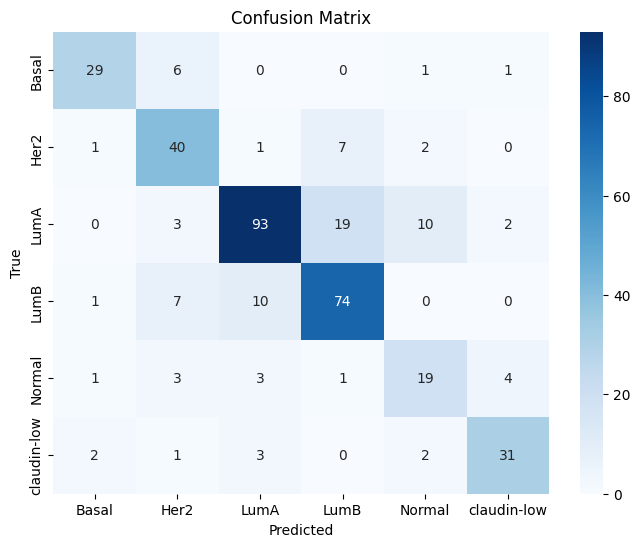

In [ ]:
labels = le.classes_
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Classification report

In [ ]:
evaluate_model(best_model, X_test, y_test, le.classes_) #, sample_weights=sample_weights_test)


Classification Report:
              precision    recall  f1-score   support

       Basal       0.85      0.78      0.82        37
        Her2       0.67      0.78      0.72        51
        LumA       0.85      0.73      0.78       127
        LumB       0.73      0.80      0.77        92
      Normal       0.56      0.61      0.58        31
 claudin-low       0.82      0.79      0.81        39

    accuracy                           0.76       377
   macro avg       0.75      0.75      0.75       377
weighted avg       0.77      0.76      0.76       377

Weighted AUROC: 0.9475


In [ ]:
print(le.classes_)

['Basal' 'Her2' 'LumA' 'LumB' 'Normal' 'claudin-low']


##ROC AUC plot

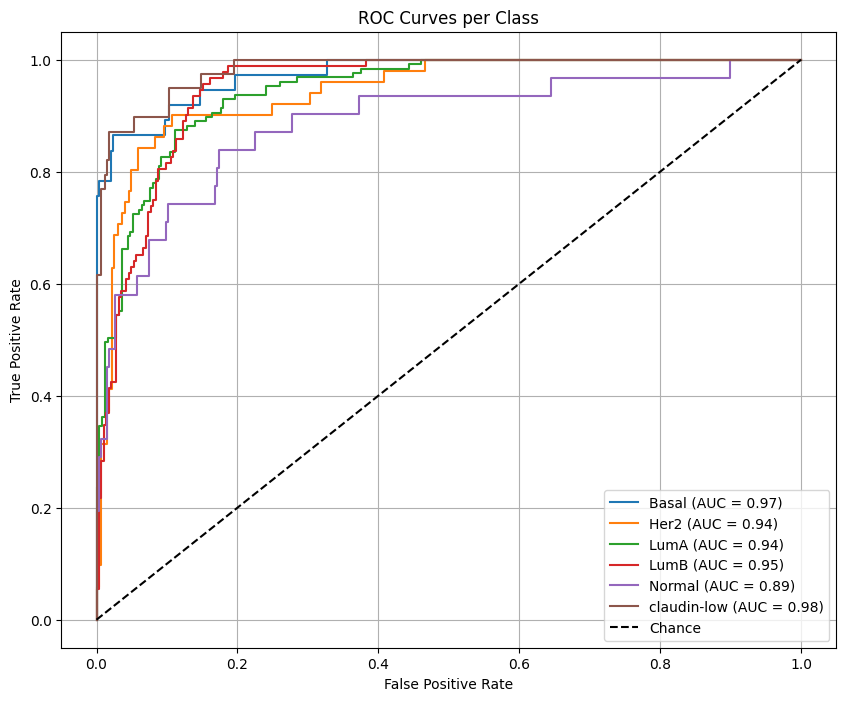

In [ ]:
y_score = best_model.predict_proba(X_test)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


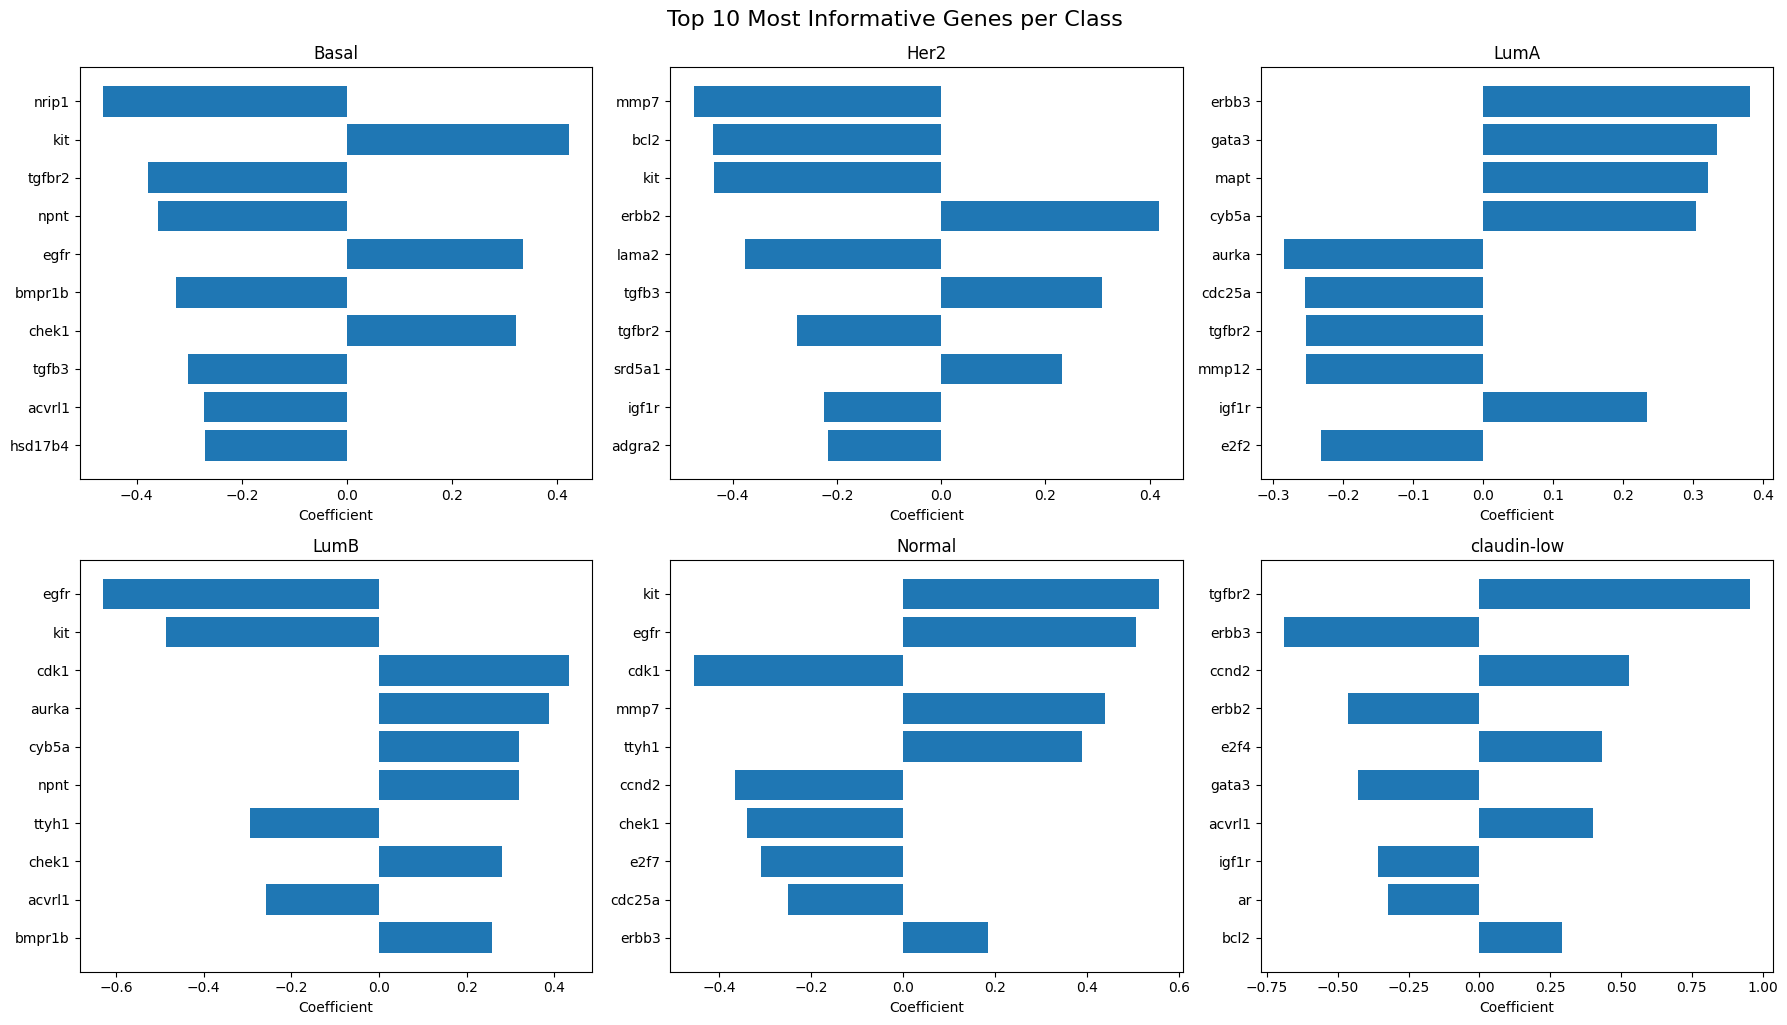

In [ ]:
# make collage
# n_classes = best_model.coef_.shape[0]

# for i in range(n_classes):
#     coefs = best_model.coef_[i]
#     sorted_idx = np.argsort(np.abs(coefs))

#     plt.figure(figsize=(20, 12))
#     plt.barh(best_model.feature_names_in_[sorted_idx], coefs[sorted_idx])
#     plt.xlabel("Coefficient")
#     plt.title(f"Class {le.classes_[i]} Coefficients")
#     plt.tight_layout()
#     plt.show()

n_classes = best_model.coef_.shape[0]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

for i in range(n_classes):
    ax = axes[i // 3, i % 3]  # row, column index
    coefs = best_model.coef_[i]
    sorted_idx = np.argsort(np.abs(coefs))[-10:]  # top 10 by magnitude

    ax.barh(best_model.feature_names_in_[sorted_idx], coefs[sorted_idx])
    ax.set_title(f"{le.classes_[i]}")
    ax.set_xlabel("Coefficient")
    #ax.grid(True)

plt.tight_layout()
plt.suptitle("Top 10 Most Informative Genes per Class", fontsize=16, y=1.02)
plt.show()


In [ ]:
coef_table = pd.DataFrame(
    best_model.coef_.T,  # Transpose to get (n_features, n_classes)
    index=best_model.feature_names_in_,
    columns=le.classes_
)

coef_table

,Basal,Her2,LumA,LumB,Normal,claudin-low
3-gene_classifier_subtype_ER+/HER2- High Prolif,-0.063705,0.177778,-0.065511,0.208213,-0.006354,-0.250421
3-gene_classifier_subtype_ER-/HER2-,0.244034,-0.148864,-0.014072,-0.055595,-0.160785,0.135281
acvrl1,-0.271866,0.094891,-0.110131,-0.257209,0.144511,0.399804
adgra2,0.208930,-0.217371,-0.075200,-0.204025,0.138445,0.149220
ahnak,-0.106779,0.109706,0.097756,-0.053034,0.063429,-0.111078
aph1b,-0.211846,-0.124973,0.020905,-0.067455,0.122561,0.260808
ar,0.016790,0.006701,0.059943,0.105767,0.133086,-0.322287
aurka,-0.161845,0.067955,-0.284182,0.387584,0.003117,-0.012629
bcl2,-0.154116,-0.437296,0.056086,0.188403,0.056726,0.290197
bmpr1b,-0.325980,-0.150035,0.091539,0.256958,0.051561,0.075957


Classes (breast cancer subtypes):
['Basal', 'Her2', 'LumA', 'LumB', 'Normal', 'claudin-low']

Aggressive subtypes (from literature): Basal, claudin-low

Top 3 genes for subtype 'Basal':
nrip1     0.464172
kit       0.422174
tgfbr2    0.377973
Name: Basal, dtype: float64

Top 3 genes for subtype 'Her2':
mmp7    0.474972
bcl2    0.437296
kit     0.435005
Name: Her2, dtype: float64

Top 3 genes for subtype 'LumA':
erbb3    0.381180
gata3    0.333885
mapt     0.321620
Name: LumA, dtype: float64

Top 3 genes for subtype 'LumB':
egfr    0.629932
kit     0.485118
cdk1    0.433102
Name: LumB, dtype: float64

Top 3 genes for subtype 'Normal':
kit     0.556943
egfr    0.505242
cdk1    0.455196
Name: Normal, dtype: float64

Top 3 genes for subtype 'claudin-low':
tgfbr2    0.955361
erbb3     0.689904
ccnd2     0.527010
Name: claudin-low, dtype: float64


--- Top gene coefficients across all classes ---

Coefficients of gene 'nrip1' across all subtypes:
Basal         -0.464172
Her2           0.0083

,Basal,Her2,LumA,LumB,Normal,claudin-low
Top 1,nrip1,mmp7,erbb3,egfr,kit,tgfbr2
Top 2,kit,bcl2,gata3,kit,egfr,erbb3
Top 3,tgfbr2,kit,mapt,cdk1,cdk1,ccnd2


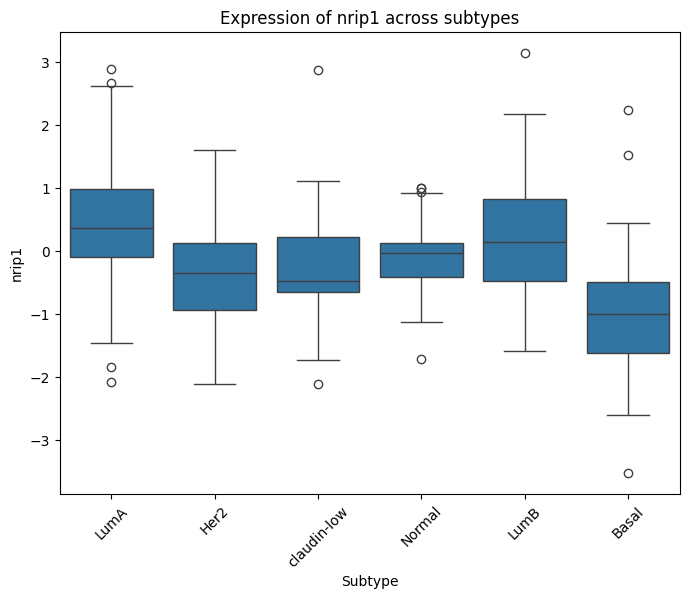

Could not save coefficients (reason: Cannot save file into a non-existent directory: '/content/drive/MyDrive/Colab_Notebooks/CS7641_ML/results')

Copy this for your report:

**Interpretation example**:
"Top marker genes for aggressive subtypes (Basal, claudin-low) are [see table above].
The coefficient for [top gene] is highest in [class], suggesting it is a strong marker for this aggressive subtype and less so for others.
This matches clinical/biological expectations (e.g., TP53 and EGFR are well-known markers of aggressive breast cancer).
Such findings support the validity and interpretability of the model for clinical applications."



In [ ]:
print("Classes (breast cancer subtypes):")
print(coef_table.columns.tolist())
print("\nAggressive subtypes (from literature): Basal, claudin-low\n")

top_genes_by_class = {}

for class_name in coef_table.columns:
    top_genes = coef_table[class_name].abs().sort_values(ascending=False).head(3)
    top_genes_by_class[class_name] = top_genes.index.tolist()
    print(f"Top 3 genes for subtype '{class_name}':")
    print(top_genes)
    print()

print("\n Top gene coefficients across all classes ")
for class_name in coef_table.columns:
    top_gene = top_genes_by_class[class_name][0]
    print(f"\nCoefficients of gene '{top_gene}' across all subtypes:")
    print(coef_table.loc[top_gene])
    print()

markers_table = pd.DataFrame.from_dict(top_genes_by_class, orient='index').T
markers_table.index = ['Top 1', 'Top 2', 'Top 3']
print("Summary: Top marker genes for each subtype:")
display(markers_table)

try:
    gene = top_genes_by_class['Basal'][0]
    plot_df = X_test.copy()
    plot_df['Subtype'] = le.inverse_transform(y_test)
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Subtype', y=gene, data=plot_df)
    plt.title(f"Expression of {gene} across subtypes")
    plt.xticks(rotation=45)
    plt.show()
except Exception as e:
    print(f"Optional plot skipped (reason: {e})")

*   which is most aggresive form, see the top coefficients, see bio implications of top 3 genes and what it means for the other classes
*   Compare those same top 3 genes to where there are in the other classes.
*   Bio statement: xx expression should be highest in xx class and less in others.
*   Bio implication, makes sense? with regards to clinical context
*   Usefulness: Markers that help differentiate classes better and suggest a very aggressive cancer type.
*   Go through models from Kaggle and take a look at accuracies, model performance. Pay attention to target column

Top marker genes per class (class names):
Basal: ['nrip1', 'kit', 'tgfbr2', 'npnt', 'egfr', 'bmpr1b']
Her2: ['mmp7', 'bcl2', 'kit', 'erbb2', 'lama2', 'tgfb3']
LumA: ['erbb3', 'gata3', 'mapt', 'cyb5a', 'aurka', 'cdc25a']
LumB: ['egfr', 'kit', 'cdk1', 'aurka', 'cyb5a', 'npnt']
Normal: ['kit', 'egfr', 'cdk1', 'mmp7', 'ttyh1', 'ccnd2']
claudin-low: ['tgfbr2', 'erbb3', 'ccnd2', 'erbb2', 'e2f4', 'gata3']

Class mapping (int label → class name): {0: 'Basal', 1: 'Her2', 2: 'LumA', 3: 'LumB', 4: 'Normal', 5: 'claudin-low'}

Class name for Basal-like: Basal, Claudin-low: claudin-low

Top Basal-like markers (Basal): ['nrip1', 'kit', 'tgfbr2', 'npnt', 'egfr', 'bmpr1b']
Top Claudin-low markers (claudin-low): ['tgfbr2', 'erbb3', 'ccnd2', 'erbb2', 'e2f4', 'gata3']

Basal-like marker gene coefficients across all classes:


,nrip1,kit,tgfbr2,npnt,egfr,bmpr1b
Basal,-0.464172,0.422174,-0.377973,-0.359371,0.334282,-0.325980
Her2,0.008305,-0.435005,-0.276037,0.118244,0.010370,-0.150035
LumA,0.175375,-0.111457,-0.252673,0.187671,-0.203047,0.091539
LumB,0.171220,-0.485118,0.045501,0.318960,-0.629932,0.256958
Normal,0.058178,0.556943,-0.094179,-0.007687,0.505242,0.051561
claudin-low,0.051095,0.052463,0.955361,-0.257817,-0.016915,0.075957



Claudin-low marker gene coefficients across all classes:


,tgfbr2,erbb3,ccnd2,erbb2,e2f4,gata3
Basal,-0.377973,0.010707,0.176663,-0.095534,0.032817,-0.063763
Her2,-0.276037,0.008262,-0.141256,0.418521,-0.146980,-0.053004
LumA,-0.252673,0.381180,-0.061748,0.207816,-0.138476,0.333885
LumB,0.045501,0.105127,-0.134540,-0.029960,-0.095571,0.135914
Normal,-0.094179,0.184629,-0.366130,-0.036095,-0.085840,0.076969
claudin-low,0.955361,-0.689904,0.527010,-0.464749,0.434051,-0.430001



Gene expression patterns for Basal markers:


/tmp/ipython-input-211-1066265254.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipython-input-211-1066265254.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipython-input-211-1066265254.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipython-input-211-1066265254.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipython-input-211-1066265254.py:68: UserWarning: set_ti

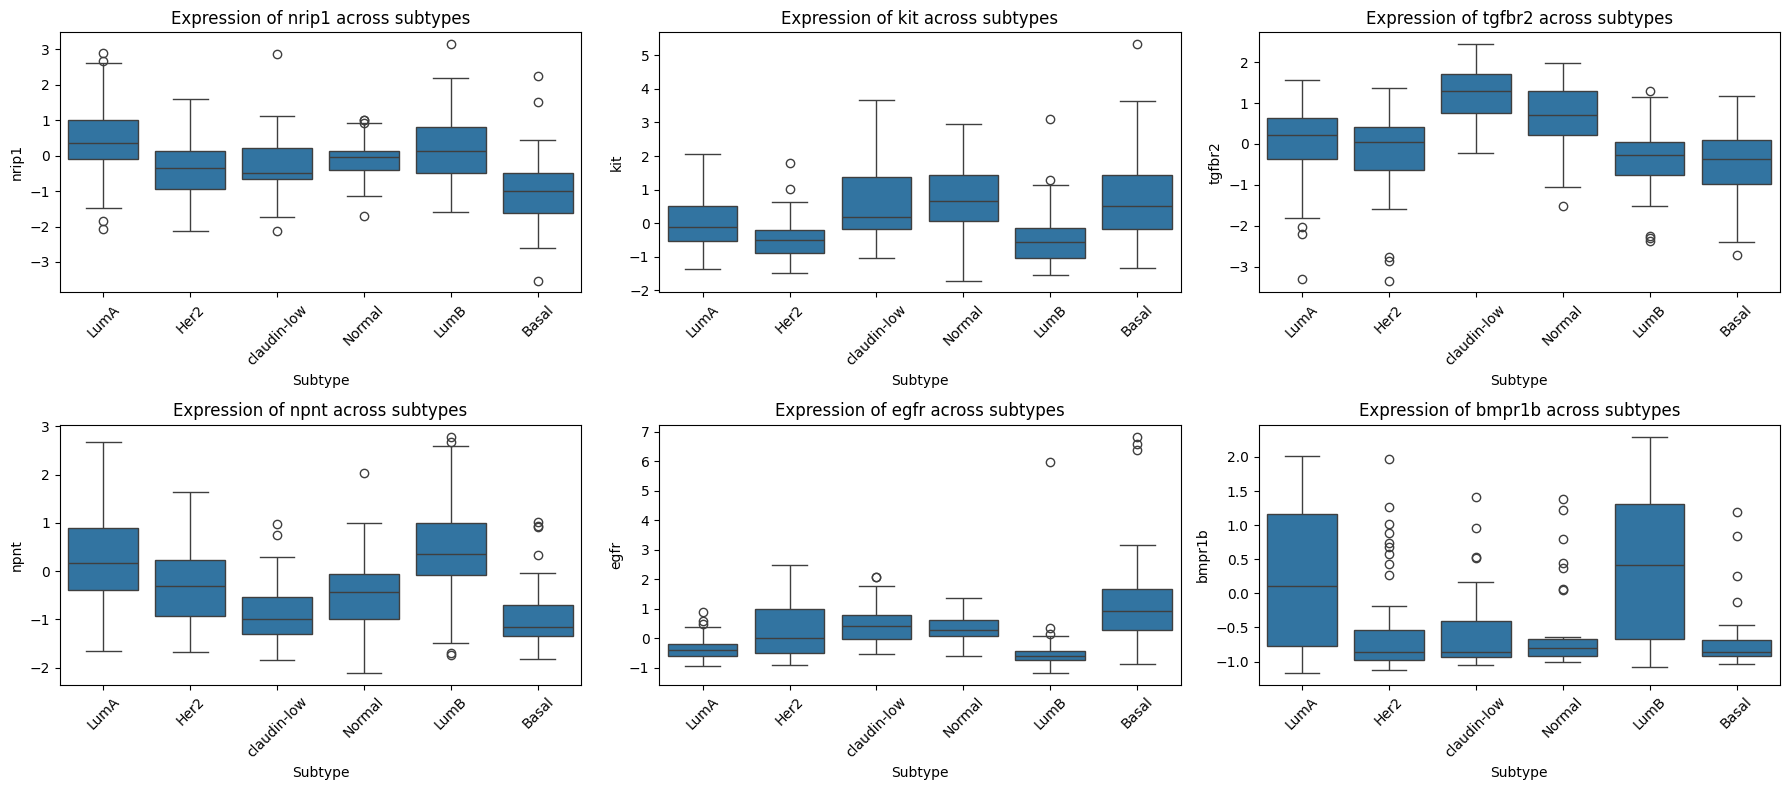


Gene expression patterns for claudin-low markers:


/tmp/ipython-input-211-1066265254.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipython-input-211-1066265254.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipython-input-211-1066265254.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipython-input-211-1066265254.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


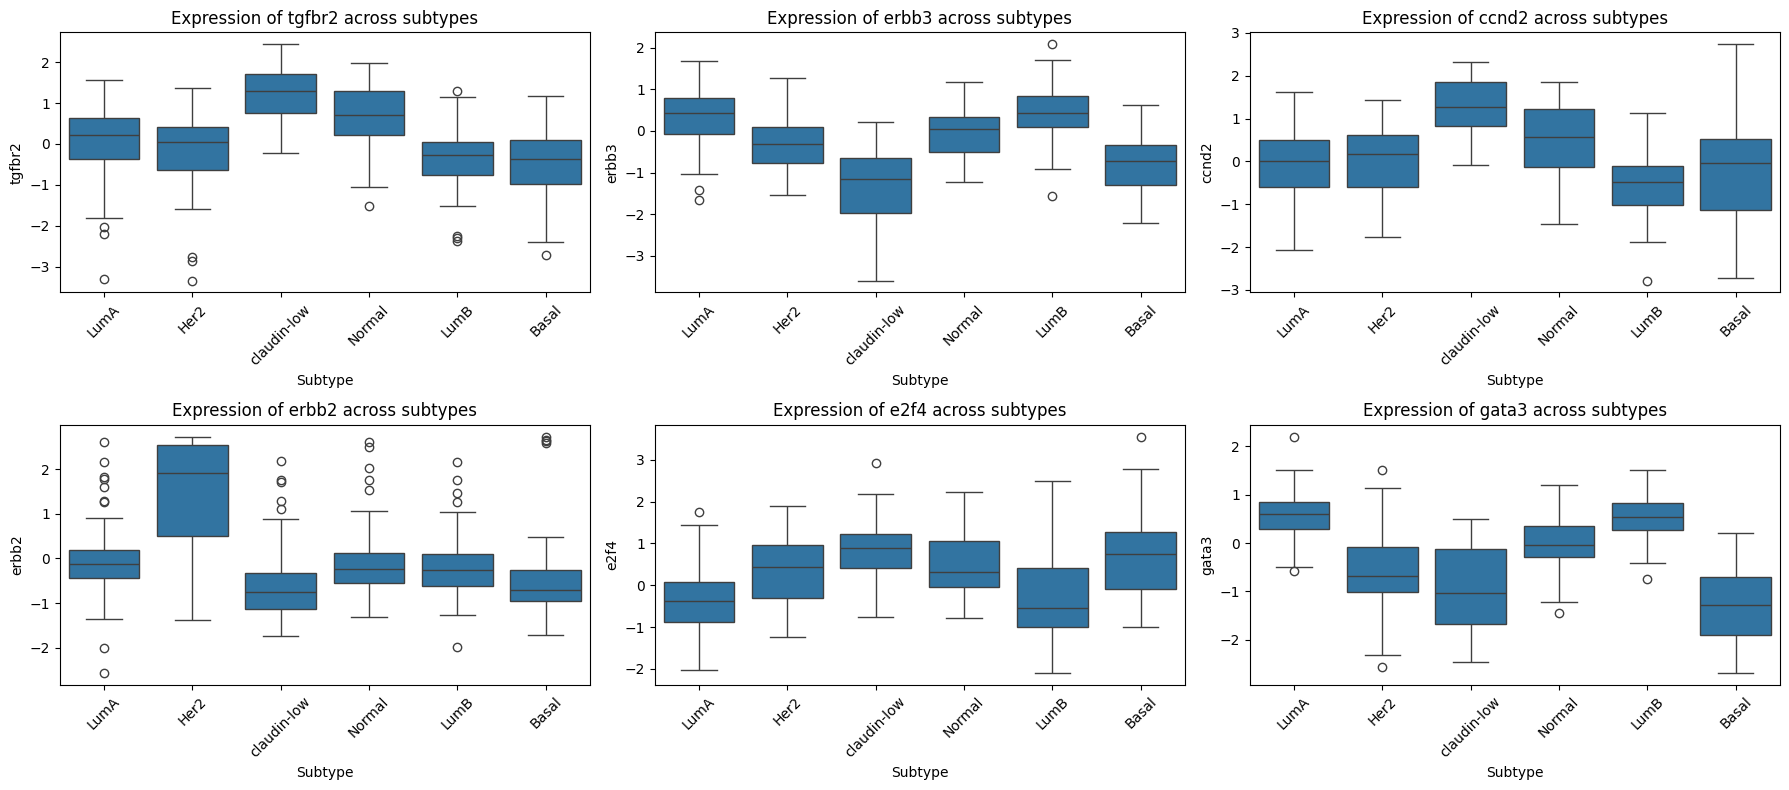


Clinical/Biological summary for Basal markers:

- **nrip1**: downregulated in Basal (coef: -0.46); highest in LumA, lowest in Basal. Consider literature for clinical significance.
- **kit**: upregulated in Basal (coef: 0.42); highest in Normal, lowest in LumB. Consider literature for clinical significance.
- **tgfbr2**: downregulated in Basal (coef: -0.38); highest in claudin-low, lowest in Basal. Consider literature for clinical significance.
- **npnt**: downregulated in Basal (coef: -0.36); highest in LumB, lowest in Basal. Consider literature for clinical significance.
- **egfr**: upregulated in Basal (coef: 0.33); highest in Normal, lowest in LumB. Consider literature for clinical significance.
- **bmpr1b**: downregulated in Basal (coef: -0.33); highest in LumB, lowest in Basal. Consider literature for clinical significance.

Clinical/Biological summary for claudin-low markers:

- **tgfbr2**: upregulated in claudin-low (coef: 0.96); highest in claudin-low, lowest in Basal. Conside

In [ ]:
# get top N marker genes for each class (by absolute coefficient)
N = 6
top_markers_by_class = {}
for cls in coef_table.columns:
    coefs = coef_table[cls]
    top_genes = coefs.abs().sort_values(ascending=False).head(N).index.tolist()
    top_markers_by_class[cls] = top_genes

print("Top marker genes per class (class names):")
for cls, genes in top_markers_by_class.items():
    print(f"{cls}: {genes}")

# map integer class labels back to class names
int_to_class = dict(enumerate(le.classes_))
print("\nClass mapping (int label → class name):", int_to_class)


basal_col = None
claudin_col = None
for name in coef_table.columns:
    if 'Basal' in name or 'basal' in name:
        basal_col = name
    if 'claudin' in name.lower():
        claudin_col = name

print(f"\nClass name for Basal-like: {basal_col}, Claudin-low: {claudin_col}")

# get top markers
basal_markers = top_markers_by_class.get(basal_col, [])
claudin_markers = top_markers_by_class.get(claudin_col, [])

print(f"\nTop Basal-like markers ({basal_col}): {basal_markers}")
print(f"Top Claudin-low markers ({claudin_col}): {claudin_markers}")


def marker_coef_table(marker_list, coef_table):
    if not marker_list:
        print("No markers to show.")
        return pd.DataFrame()
    display_df = coef_table.loc[marker_list].T
    display(display_df)
    return display_df

print("\nBasal-like marker gene coefficients across all classes:")
_ = marker_coef_table(basal_markers, coef_table)

print("\nClaudin-low marker gene coefficients across all classes:")
_ = marker_coef_table(claudin_markers, coef_table)

# box plots for top marker genes
X_test_df = pd.DataFrame(X_test, columns=best_model.feature_names_in_) if not isinstance(X_test, pd.DataFrame) else X_test
y_test_labels = le.inverse_transform(y_test) if hasattr(le, "inverse_transform") else y_test

def plot_marker_expression(marker_genes, X, y, palette=None, n_cols=3):
    if not marker_genes:
        print("No marker genes to plot.")
        return
    n_rows = int(np.ceil(len(marker_genes) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    for i, gene in enumerate(marker_genes):
        if gene not in X.columns:
            print(f"Gene {gene} not found in X_test columns, skipping.")
            continue
        plot_df = pd.DataFrame({gene: X[gene], 'Subtype': y})
        sns.boxplot(x='Subtype', y=gene, data=plot_df, ax=axes[i], palette=palette)
        axes[i].set_title(f'Expression of {gene} across subtypes')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

    for i in range(len(marker_genes), len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

if basal_markers:
    print(f"\nGene expression patterns for {basal_col} markers:")
    plot_marker_expression(basal_markers, X_test_df, y_test_labels)
else:
    print(f"\nNo marker genes found for {basal_col}. Skipping plot.")

if claudin_markers:
    print(f"\nGene expression patterns for {claudin_col} markers:")
    plot_marker_expression(claudin_markers, X_test_df, y_test_labels)
else:
    print(f"\nNo marker genes found for {claudin_col}. Skipping plot.")


def marker_report(markers, coef_table, class_name):
    lines = []
    for gene in markers:
        coefs = coef_table.loc[gene]
        main_coef = coefs[class_name]
        highest = coefs.idxmax()
        lowest = coefs.idxmin()
        direction = "upregulated" if main_coef > 0 else "downregulated"
        lines.append(
            f"- **{gene}**: {direction} in {class_name} (coef: {main_coef:.2f}); " +
            f"highest in {highest}, lowest in {lowest}. " +
            f"Consider literature for clinical significance."
        )
    return "\n".join(lines)

if basal_markers:
    print(f"\nClinical/Biological summary for {basal_col} markers:\n")
    print(marker_report(basal_markers, coef_table, basal_col))

if claudin_markers:
    print(f"\nClinical/Biological summary for {claudin_col} markers:\n")
    print(marker_report(claudin_markers, coef_table, claudin_col))